In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [3]:
def readtextfile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [4]:
captions = readtextfile("./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]
print(len(captions))

40460


In [5]:
captions[2]

'1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .'

In [6]:
#Dictionary to map each Image with list of captions it has

In [7]:
description = {}

for i in captions:
    first,second = i.split('\t')
    img_name = first.split(".")[0]
    
    if description.get(img_name) is None:
        description[img_name] = []
    description[img_name].append(second)

In [8]:
description.values

<function dict.values>

In [9]:
####Data cleaning


In [10]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    
    return sentence

In [11]:
clean_text("house no - 128")

'house no'

In [12]:
#Clean all captions

In [13]:
for key,caption_list in description.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [14]:
description["1000268201_693b08cb0e"]


['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [15]:
#Write data to a text file

In [16]:
f = open("descriptions.txt","w")
f.write(str(description))
f.close()

In [17]:
## Creating a Vocab

In [18]:
## If we want to take data from a text
description = None
with open("descriptions.txt",'r') as f:
    description= f.read()
    
json_acceptable_string = description.replace("'","\"")
description = json.loads(json_acceptable_string)

In [19]:
vocab = set()
for key in description.keys():
    [vocab.update(sentence.split()) for sentence in description[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [20]:
##Alternate
vocab = set()
for key in description.keys():
    for sen in description[key]:
        vocab.update(sen.split())

In [21]:
print(len(vocab))

8424


In [22]:
#Total words
total_words=[]

for key in description.keys():
    for sen in description[key]:
        for i in sen.split():
            total_words.append(i)
            

In [23]:
print(len(total_words))

373837


In [24]:
total_words[:10]

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']

In [25]:
import collections

counter= collections.Counter(total_words)
freq_cnt = dict(counter)


In [26]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key =lambda x:x[1])

In [27]:
print(type(sorted_freq_cnt))

<class 'list'>


In [28]:
print(sorted_freq_cnt[:10])

[('in', 18987), ('the', 18420), ('on', 10746), ('is', 9345), ('and', 8863), ('dog', 8138), ('with', 7765), ('man', 7275), ('of', 6723), ('two', 5643)]


In [29]:
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]> 10]

In [30]:
total_words = [x[0] for x in sorted_freq_cnt]

In [31]:
len(total_words)

1845

In [32]:
## Prepare Test And Train Data

In [33]:
train_file_data = readtextfile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readtextfile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [34]:
print(type(train_file_data))

<class 'str'>


In [35]:
train = [row.split('.')[0] for row in train_file_data.split('\n')[:-1]]

In [36]:
train

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [37]:
test = [row.split('.')[0] for row in test_file_data.split('\n')[:-1]]

In [38]:
test[:10]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01',
 '2654514044_a70a6e2c21',
 '2339106348_2df90aa6a9',
 '256085101_2c2617c5d0',
 '280706862_14c30d734a',
 '3072172967_630e9c69d0']

In [39]:
## Adding start and end to each caption

In [40]:
train_description={}

for img_id in train:
    train_description[img_id] = []
    for caption in description[img_id]:
        cap_to_add = "startseq " + caption + " endseq"
        train_description[img_id].append(cap_to_add)

In [41]:
train_description["2513260012_03d33305cf"]

['startseq black dog is running after white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through low lying body of water endseq']

In [42]:
## Transfer Learning

In [43]:
model = ResNet50(weights = "imagenet",input_shape = (224,224,3))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_________

In [44]:
model_new = Model(model.input,model.layers[-2].output)

In [45]:
import cv2

In [46]:
def preprocess_img(img):
    img = image.load_img(img,target_size = (224,224))
    
    img = image.img_to_array(img)
    
    img = np.expand_dims(img,axis = 0)
    
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


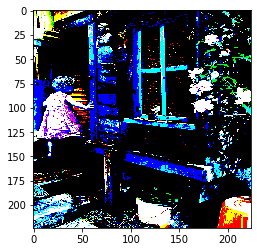

In [47]:
img = preprocess_img("Flickr_Data/Flickr_Data/Images/1000268201_693b08cb0e.jpg")
print(img.shape)
plt.imshow(img[0])

In [48]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
   
    feature_vector  = feature_vector.reshape((-1,))
    return feature_vector

In [49]:
encode_img("Flickr_Data/Flickr_Data/Images/1000268201_693b08cb0e.jpg")

array([0.04154464, 0.17075905, 0.29276785, ..., 0.05094026, 0.3131964 ,
       0.8600726 ], dtype=float32)

In [50]:
encoding_train ={}
#image-id -> feature vector


In [51]:
IMG_PATH = "Flickr_Data/Flickr_Data/Images"
for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/" +img_id +".jpg"
    encoding_train[img_id] = encode_img(img_path)

KeyboardInterrupt: 

In [ ]:
print(encode_img("Flickr_Data/Flickr_Data/Images/2513260012_03d33305cf.jpg"))


In [52]:
with open("encoding_train_features.pkl",'wb') as f:
    pickle.dump(encoding_train,f)

In [97]:
start = time()
encoding_test = {}

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/" +img_id +".jpg"
    encoding_test[img_id]= encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in progress Time Step %d"%ix)
        
end_t = time();
print("Total Time : ",end_t-start)

Encoding in progress Time Step 0
Encoding in progress Time Step 100
Encoding in progress Time Step 200
Encoding in progress Time Step 300
Encoding in progress Time Step 400
Encoding in progress Time Step 500
Encoding in progress Time Step 600
Encoding in progress Time Step 700
Encoding in progress Time Step 800
Encoding in progress Time Step 900
Total Time :  397.3522045612335


In [98]:
with open("encoding_test_features.pkl",'wb') as f:
    pickle.dump(encoding_test,f)

In [100]:
## Pre Procesing Captions
encoding_train

{'2513260012_03d33305cf': array([0.28047293, 0.4068742 , 0.0837997 , ..., 0.9107919 , 0.04341818,
        0.09577907], dtype=float32),
 '2903617548_d3e38d7f88': array([0.        , 0.00244131, 0.07775956, ..., 0.3222457 , 0.33872557,
        0.8269819 ], dtype=float32),
 '3338291921_fe7ae0c8f8': array([0.6499889 , 0.45327288, 0.35990602, ..., 0.01184073, 0.17420341,
        0.04910818], dtype=float32),
 '488416045_1c6d903fe0': array([0.5911424 , 0.24315467, 0.        , ..., 1.1071401 , 0.4421182 ,
        0.41112936], dtype=float32),
 '2644326817_8f45080b87': array([0.08373524, 0.553748  , 0.03665283, ..., 0.11103815, 1.0484878 ,
        0.        ], dtype=float32),
 '218342358_1755a9cce1': array([1.5750586 , 0.3306425 , 0.34105504, ..., 0.24407986, 0.03760241,
        0.03851028], dtype=float32),
 '2501968935_02f2cd8079': array([0.08495868, 1.2882221 , 0.03415359, ..., 0.1563588 , 0.5512882 ,
        1.335881  ], dtype=float32),
 '2699342860_5288e203ea': array([0.34911206, 0.30767426, 

In [56]:
word_to_idx = {}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [57]:
word_to_idx["run"]

161

In [58]:
idx_to_word[180]

'skateboarder'

In [59]:
idx_to_word[1846] = "startseq"
word_to_idx["startseq"] = 1846

idx_to_word[1847] = "endseq"
word_to_idx["endseq"] = 1847

In [60]:
vocab_size = len(word_to_idx) + 1
vocab_size

1848

In [61]:
max_len=0
for key in train_description.keys():
        for cap in train_description[key]:
            max_len = max(max_len,len(cap.split()))

print(max_len)

35


In [62]:
train_description["2513260012_03d33305cf"][2].split()

['startseq',
 'two',
 'dogs',
 'chase',
 'each',
 'other',
 'across',
 'the',
 'snowy',
 'ground',
 'endseq']

In [91]:
encoding_test

{'3385593926_d3e9c21170': array([0.2823609 , 0.31681862, 0.04513445, ..., 0.74424076, 0.29651454,
        0.920625  ], dtype=float32),
 '2677656448_6b7e7702af': array([0.23351432, 0.05175799, 0.6238553 , ..., 0.00523912, 0.26226747,
        0.08674015], dtype=float32),
 '311146855_0b65fdb169': array([0.00912255, 0.07216533, 0.1220391 , ..., 0.02202931, 1.131913  ,
        0.03853815], dtype=float32),
 '1258913059_07c613f7ff': array([0.02427802, 1.2347151 , 0.07595009, ..., 0.08897495, 0.09812588,
        1.9384055 ], dtype=float32),
 '241347760_d44c8d3a01': array([0.0505117 , 6.3199897 , 0.3120082 , ..., 0.05379438, 0.01552999,
        0.02812625], dtype=float32),
 '2654514044_a70a6e2c21': array([1.7662996 , 0.03384979, 0.10334545, ..., 0.00532009, 0.6680156 ,
        0.39294165], dtype=float32),
 '2339106348_2df90aa6a9': array([0.06683154, 1.0869427 , 0.07896088, ..., 0.01411188, 0.1311434 ,
        0.09507965], dtype=float32),
 '256085101_2c2617c5d0': array([0.5742956 , 0.51020324, 0

In [64]:
## DATA LOADER (GENERATOR)

In [65]:
def data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n = 0
    while True:
        for key,desc_list in train_description.items():
            n+=1
            
            photo = encoding_train[key]
            
            for cap in desc_list:
                seq = [word_to_idx[word] for word in cap.split() if word in word_to_idx]
                
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi= seq[i]
                    
                    xi = pad_sequences([xi],maxlen=max_len,value = 0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
            if n==batch_size:
                yield [[np.array(X1),np.array(X2)],np.array(y)]
                
                X1,X2,y = [],[],[]
                n=0
                    

In [66]:
vocab_size

1848

In [67]:
##WORD EMBEDDINGS

In [68]:
f = open("./glove.6B.50d.txt",encoding='utf8')

In [69]:
embedding_index={}

for line in f:
    values = line.split()
    word = values[0]
    embedding_word = np.array(values[1:],dtype = 'float')
    embedding_index[word] = embedding_word

In [70]:
f.close()

In [71]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [72]:
def get_embedding_matrix():
    emb_dim = 50
    
    matrix = np.zeros((vocab_size,emb_dim))
    
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    
    return matrix

In [73]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [74]:
print(embedding_matrix[18])
print(idx_to_word[18])

[-1.1059    0.40883  -0.75338  -0.72444   1.03      0.045399 -0.63381
 -0.79198  -0.34847  -0.824     0.43937  -0.56107  -0.066033  0.50741
  0.27729   0.34504  -1.1487    0.078797 -0.39566  -1.4519   -0.78454
  1.1854    0.050496 -0.26502  -1.127    -1.8098   -0.89228   1.4199
  0.51537  -1.1537    1.5758    0.88734  -0.68114   0.014502  0.266
  0.92511   0.48301  -0.11315  -0.92386  -0.11854   0.035215  0.72933
  0.15398   0.46788   1.3891   -1.4336   -0.24537  -1.3055   -0.057538
 -0.4754  ]
wearing


In [75]:
##MODEL ARCHITECTURE

In [76]:
input_img_features = Input(shape=(2048,))
inp_img1= Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [77]:
## Captions as Input

In [78]:
input_captions = Input(shape=(max_len,))
inp_cap1= Embedding(input_dim=vocab_size,output_dim = 50,mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [79]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)


model = Model(inputs = [input_img_features,input_captions],outputs = outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [80]:
model.layers[2].set_weights = embedding_matrix
model.layers[2].trainable = False

In [81]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [82]:
##Training

In [212]:
epochs = 20
batch_size = 3
steps = len(train_description)

In [227]:
def train():
    for i in range(epochs):
        print(i)
        generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs = 1,steps_per_epoch=steps,verbose = 1)
        model.save('./model_weights/model_'+str(i)+'.h5')
        

In [228]:
train()

0
Epoch 1/1
6000/6000 [==============================] - 1972s 329ms/step - loss: 3.7124
1
Epoch 1/1
6000/6000 [==============================] - 2012s 335ms/step - loss: 3.4533
2
Epoch 1/1
6000/6000 [==============================] - 2098s 350ms/step - loss: 3.2823
3
Epoch 1/1
6000/6000 [==============================] - 1953s 325ms/step - loss: 3.1600
4
Epoch 1/1
6000/6000 [==============================] - 1988s 331ms/step - loss: 3.0643
5
Epoch 1/1
6000/6000 [==============================] - 2020s 337ms/step - loss: 2.9914
6
Epoch 1/1
6000/6000 [==============================] - 2036s 339ms/step - loss: 2.9267
7
Epoch 1/1
6000/6000 [==============================] - 2061s 344ms/step - loss: 2.8738
8
Epoch 1/1
6000/6000 [==============================] - 2108s 351ms/step - loss: 2.8280
9
Epoch 1/1
6000/6000 [==============================] - 18031s 3s/step - loss: 2.7883
10
Epoch 1/1
6000/6000 [==============================] - 2046s 341ms/step - loss: 2.7548
11
Epoch 1/1
6000/6000

In [83]:
model = load_model('./model_weights/model_19.h5')

In [95]:
 def prediction_caption(photo):
        in_text ="startseq"
        for i in range(max_len):
            sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
            sequence  =pad_sequences([sequence],maxlen = max_len,padding = 'post')
            
            ypred = model.predict([photo,sequence])
            ypred = ypred.argmax()
            word = idx_to_word[ypred]
            in_text += ' '+word
            if word =="endseq":
                break
                
        final_caption = in_text.split()[1:-1]
        final_caption = ' '.join(final_caption)
        
        return final_caption

In [89]:
all_img_names = list(encoding_test.keys())
all_img_names

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01',
 '2654514044_a70a6e2c21',
 '2339106348_2df90aa6a9',
 '256085101_2c2617c5d0',
 '280706862_14c30d734a',
 '3072172967_630e9c69d0',
 '3482062809_3b694322c4',
 '1167669558_87a8a467d6',
 '2847615962_c330bded6e',
 '3344233740_c010378da7',
 '2435685480_a79d42e564',
 '3110649716_c17e14670e',
 '2511019188_ca71775f2d',
 '2521770311_3086ca90de',
 '2723477522_d89f5ac62b',
 '2218609886_892dcd6915']

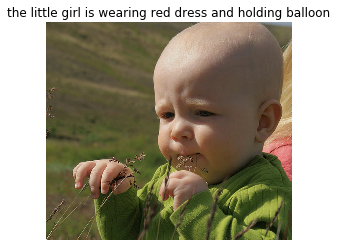

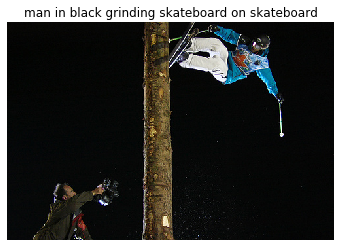

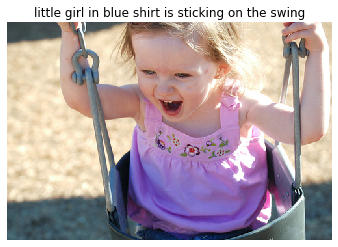

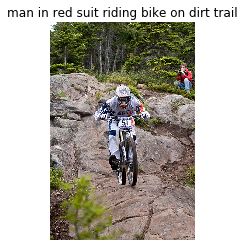

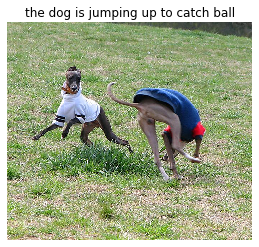

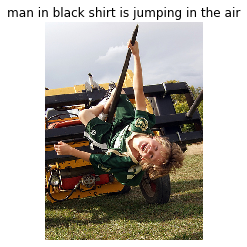

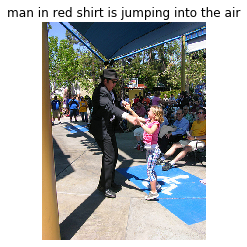

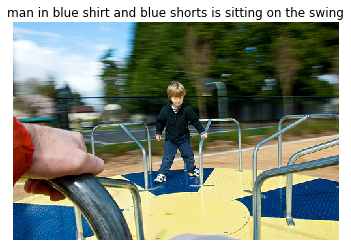

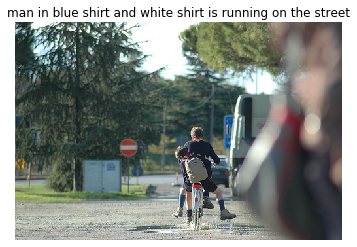

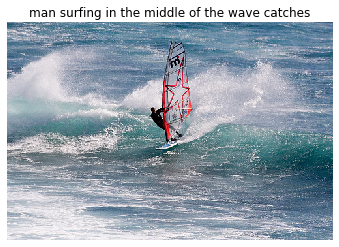

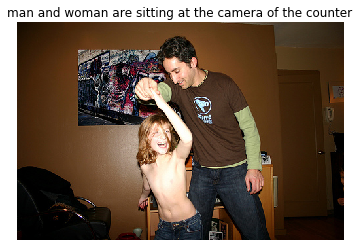

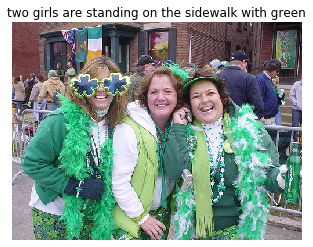

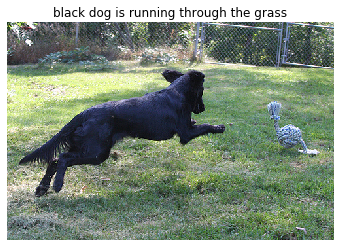

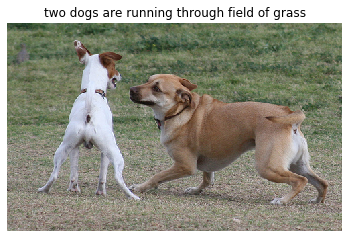

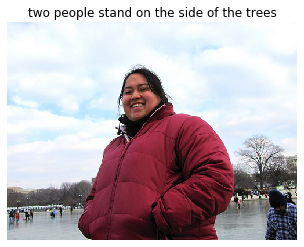

In [101]:
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = prediction_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()